In [836]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from split import *
from score import *
from scipy import interpolate
import time 
%matplotlib inline 
import warnings 
warnings.simplefilter('ignore', np.RankWarning)
import matplotlib.pyplot as plt
import matplotlib

"""
Title:       Search_By_Triplet + TIME_RESOLUTION.

Autor:       Piter Amador Paye Mamani.

Description:
             This python-code is an implementation of the algorithm Search By Triplet that was inspired on the work of
             Daniel Campora.           
Changes:
1.  Squeletum of the algorithm
2.  First Tracks. 
3. 
4. 
5.  Adding exceptions. 
6.  I've deleted unnecessary comments. Also, I was getting an error at time to compute findcandidatewindows.
    Problems. One get the values of tracks 
7.  Changing the jerarquy of the function, according to the paper. It means that findcandidatewindows is calculated
    on all modules befero they were processed.
6. 
7. 
8.  I've added the information of weak_tracks and I've added the information of USED and NOt USED 
9.  dphi  is a constant value
9.  Adding timing information 


10. In this version I will plot a graphic of efficiency in function of dphi. 
    Here, I am not concentrating on the plots of the tracks. Only on the plots of the efficiency that depend on dphi.
    In other words. I have to run the main program and get the values of the efficiency and then plot. 
    I am thinking on work only with 0.004 percent of the data. Because it is more fast than all data. 
    
11. Adding TIMING TO THE ALGORITHM.     
    To add timing information to the algorithm 
    I've do it previoues analysis like see if the time difference follow a gaussian distribution.
    Plus another important question is to see. How we can add the new restriction to our values. 
    
    I refer that I have to compute the difference in time between t1 and t2 to see if the values surpasses a new technological approach. 


=============================================
To implement : 

def search_by_triplet (..., time=True):
      ...
      if time:  # on all cases where be necessary
          # implement timing information here 

=============================================

"""

"\nTitle:       Search_By_Triplet + TIME_RESOLUTION.\n\nAutor:       Piter Amador Paye Mamani.\n\nDescription:\n             This python-code is an implementation of the algorithm Search By Triplet that was inspired on the work of\n             Daniel Campora.           \nChanges:\n1.  Squeletum of the algorithm\n2.  First Tracks. \n3. \n4. \n5.  Adding exceptions. \n6.  I've deleted unnecessary comments. Also, I was getting an error at time to compute findcandidatewindows.\n    Problems. One get the values of tracks \n7.  Changing the jerarquy of the function, according to the paper. It means that findcandidatewindows is calculated\n    on all modules befero they were processed.\n6. \n7. \n8.  I've added the information of weak_tracks and I've added the information of USED and NOt USED \n9.  dphi  is a constant value\n9.  Adding timing information \n\n\n10. In this version I will plot a graphic of efficiency in function of dphi. \n    Here, I am not concentrating on the plots of the t

In [837]:
def rho(x,y):
    return np.sqrt(x*x + y*y)
def r(x,y,z):
    return np.sqrt(x*x + y*y + z*z)
def theta(x,y,z):
    return np.arccos(z/r(x,y,z))
def phi(x,y):
    return np.arctan(y/x)
def module(r):
    return np.sqrt(np.sum(r*r))
def r_e(z, r_l, r_c):
    z_c = r_c[2] 
    r_versor = (r_l - r_c)/module(r_l - r_c)               # computing r_versor
    r_versor_dot_z_versor = r_versor[2]  
    return r_c - r_versor/r_versor_dot_z_versor*(z_c - z)  # IMPORTANT WITH THE MINUS SIGN.
def correct_time(hit_time, x, y, z):
    c = 0.299792 #[cm/ps] Light Velocity in [centimeters & pico seconds]
    travel_time = np.sqrt(x*x + y*y + z*z)/c
    return hit_time - travel_time    

In [838]:


def reading_data(fraction, event):
    global time_resolution           # Adding a time resolution to our analysis of tracks
    """
    EVENT
    55microns50psInner55microns50psOuter_EventNumber.txt
    
    25microns0psInner200microns50psOuter_test.txt
    25microns0psInner200microns50psOuter_train.txt
    25microns75psInner25microns75psOuter_test.txt
    25microns75psInner25microns75psOuter_train.txt
    55microns0psInner55microns0psOuter_test.txt
    55microns0psInner55microns0psOuter_train.txt
    55microns100psInner200microns50psOuter_test.txt
    55microns100psInner200microns50psOuter_train.txt
    55microns50psInner55microns50psOuter_test.txt
    55microns50psInner55microns50psOuter_train.txt
    
    RAMPData25microns0psInner200microns50psOuter_test.txt
    RAMPData25microns0psInner200microns50psOuter_train.txt
    RAMPData25microns75psInner25microns75psOuter_test.txt
    RAMPData25microns75psInner25microns75psOuter_train.txt
    RAMPData55microns0psInner55microns0psOuter_test.txt
    RAMPData55microns0psInner55microns0psOuter_train.txt
    RAMPData55microns100psInner200microns50psOuter_test.txt
    RAMPData55microns100psInner200microns50psOuter_train.txt
    RAMPData55microns50psInner200microns50psOuter_test.txt
    RAMPData55microns50psInner200microns50psOuter_train.txt
    RAMPData55microns50psInner55microns50psOuter_test.txt
    RAMPData55microns50psInner55microns50psOuter_train.txt
    RAMPsmeared55microns200psInner55microns50psOuter_test.txt
    RAMPsmeared55microns200psInner55microns50psOuter_train.txt
    test.txt
    testTrain.txt
    """
    name = 'data2/55microns50psInner55microns50psOuter_EventNumber.txt' # To be modified for others files. 
    
    df = pd.DataFrame()
    df = pd.read_csv(name, sep=' ')              # All data.
    
    columns = df.columns.values
    columns[9] = 'Event'
    df.columns = columns

    df_tmp = df.query(f'Event == {event}' ) #.copy(deep = True)  # inplace=True)

    
    df_tmp2, _ = split_frac(df_tmp, fraction)
    
    return df_tmp2        

In [839]:
def sortbyphi():
    global time_resolution               # Adding a time resolution to our analysis of tracks

    global df 
    # IMPORTANT, the dataframe will be modified with the values of the z_CORRECT.
    '''Description:
    Sort each D_i increasingly accoording to phi
    And add a column to the dataframe_module with the name of used to accept or neglect hits. 
    '''
    global sigma_z 

    # Creating new variables to 
    df['phi']   = np.arctan(df['x']/df['y'])                        
    df['t_c']   = correct_time(df['t'], df['x'], df['y'], df['z'])        
    df['used']  = False                                             
    #print("Index ", df.columns)
    
    modules = []
    z_modules = [-277.0, -252.0, -227.0, -202.0, -132.0, -62.0, -37.0, -12.0, 13.0, 38.0, 63.0, 88.0, 113.0, 138.0, 163.0, 188.0, 213.0, 238.0, 263.0, 325.0, 402.0, 497.0, 616.0, 661.0, 706.0, 751.0]
    
    for z_m in z_modules:  
        #print(sigma_z)
        mod = df.query(f" {z_m} - {sigma_z} <= z <= {z_m} + {sigma_z}").copy(deep=True)
        mod['z_mod'] = z_m
        #mod.loc[mod.index.values, "z_mod"] = z_m
        #mod.loc[mod.index.values, "used"]  = False
        # IMPORTANT        
        mod = mod.sort_values('phi', ascending=True)
        #print("Index ", mod['t_c'])
        modules.append(mod)  
    tmp_df =pd.DataFrame()
    for mod in modules:
        tmp_df = pd.concat([tmp_df, mod])
    df = tmp_df
    #print(df['t_c'])
    return modules

In [840]:
#PHI = []
def findcandidatewindows(left_mod, mod, right_mod ):
    #global left_mod, mod, right_mod
    #(left_mod, mod, right_mod ):
    global time_resolution               # Adding a time resolution to our analysis of tracks
    # phi_window     =  phi_extrapolation_base + np.abs( hit_Zs[h_center]) * phi_extrapolation_coef 
    global phi_extrapolation_coef, phi_extrapolation_base , dphi
    '''Description: 
        Compute the first and last candidates(the window) according to acceptance range(dphi) for each hit.
        SUPPOSSING THAT ALL DATA ARE ORDERED ACCOURDING TO PHI. THIS PROCCESS WAS DONE Previously
        In case of add more information to the modules, one easily can add throught the iteration 
    '''
    # CONVENTION :     
    # l_m  m  r_m   the values are ordered.      
    #  |   |   |             
    #  |   |   |    phi up  
    #  |   |   |    phi      
    #  |   |   |    phi down 
    #  |   |   |          
    
    right_hit_max = [] 
    right_hit_min = [] 

    temporal = mod['phi'] 
    
    # ITERATION OVER PHI FOR RIGHT 
    
    for phi_i in mod['phi']: 
        #print("=")
        #print(phi_i)
        if str(phi_i) == 'nan' :     
            #print(phi_i, "the value of phi_i is NaN ON RIGHT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            right_hit_min.append(m) 
            right_hit_max.append(M) 
            continue # 
        if str(phi_i) == 'NaN' :     
            #print(phi_i, "the value of phi_i is NaN ON RIGHT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            continue # 
            
        
        z_center = mod['z_mod'].unique()[0]
        #z = df.query(f"phi=={phi_i}")["z"].values[0]
        # GET HIT 
        """ dphi =  phi_extrapolation_base + np.abs( z_center ) * phi_extrapolation_coef """

        #PHI.append(dphi)

        down      = phi_i - dphi 
        up        = phi_i + dphi 
        #print(down, up)
        
        condition = f'{down} <= phi <=  {up}'
        tmp_df = right_mod.query(condition)
        if not tmp_df.empty:
            m = tmp_df['hit_id'][tmp_df.index[0]]     # minumum hit 
            M = tmp_df['hit_id'][tmp_df.index[-1]]    # maximum hit 
            right_hit_min.append(m) 
            right_hit_max.append(M) 
        elif tmp_df.empty :

            m = "nan" #pd.np.nan                      # minumum hit 
            M = "nan" #pd.np.nan                      # maximum hit
            right_hit_min.append(m)  
            right_hit_max.append(M) 
            
    left_hit_max = [] 
    left_hit_min = [] 
    # ITERATION OVER PHI FOR LEFT
    for phi_i in mod['phi']:
        if str(phi_i) == 'NaN' :     
            # print(phi_i, "the value of phi_i is NaN ON LEFT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            continue # 
        if str(phi_i) == 'nan' :     
            # print(phi_i, "the value of phi_i is NaN ON left")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            continue # 
        # GET HIT 
        down      = phi_i - dphi 
        up        = phi_i + dphi 
        condition = f'{down} <= phi <= {up}'
        tmp_df = left_mod.query(condition)
        #print("len LEFT", len(tmp_df))
        if not tmp_df.empty :
            m = tmp_df['hit_id'][tmp_df.index[0]]        # minumum hit 
            M = tmp_df['hit_id'][tmp_df.index[-1]]       # maximum hit  
            left_hit_min.append(m)
            left_hit_max.append(M)
        elif tmp_df.empty :
            # print("data_frame is empty LEFT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            
    mod["right_hit_max"] = right_hit_max  
    mod["right_hit_min"] = right_hit_min  
    mod["left_hit_max"]  = left_hit_max   
    mod["left_hit_min"]  = left_hit_min                                                                                    
    return mod

###############################################

In [841]:
T_L = []
T_R = []
T_C = []

def trackseeding():
    global M_i
    global time_resolution               # Adding a time resolution to our analysis of tracks

    global left_mod, mod, right_mod, M_i, dphi, sigma_t
    '''
    Description: 
        Checks the preceding and following modules for compatible hits using the above results.
        
        All triplets in the search window are fitted and compared.
        
        and the best one is kept as a track seed.
        
        stores its best found triplet
        Finding triplets is ap- plied in first instance to the modules
        that are further apart from the collision point
        Each triplet is the seed of a forming track
    '''
    #Necessary functions.
    def fit(triplet): 
        phi_data = [ df.query(f'hit_id == {hit}')['phi'] for hit in triplet ]
        z_data   = [ df.query(f'hit_id == {hit}')['z_mod']   for hit in triplet ]
        phi_data = [ hit.values[0] for hit in phi_data                      ]                        
        z_data   = [ hit.values[0] for hit in z_data                        ]                    
        # Kind of fit: Linear
        fitting = np.polyfit(phi_data, z_data, 1)
        
        chiSquared = np.sum((np.polyval(fitting, z_data) - phi_data)**2)
        return chiSquared

    df_triplets = []
    
    #print("error ??????", mod )
    
    for index, part in mod.iterrows():

        r_hit_max, r_hit_min = part["right_hit_max"], part["right_hit_min"]  
        l_hit_max, l_hit_min = part["left_hit_max"],  part["left_hit_min" ] 
        
        if  str(r_hit_max)  == "nan":
            continue 
        elif str(r_hit_min) == "nan":
            continue 
        elif str(l_hit_max) == "nan":
            continue 
        elif str(l_hit_min) == "nan":
            continue  
        if  str(r_hit_max)  == "NaN" :
            continue 
        elif str(r_hit_min) == "NaN" :
            continue 
        elif str(l_hit_max) == "NaN" :
            continue 
        elif str(l_hit_min) == "NaN" :
            continue  
        r_phi_max = right_mod.query(f"hit_id == {r_hit_max}")['phi'].values[0]
        r_phi_min = right_mod.query(f"hit_id == {r_hit_min}")['phi'].values[0] 
        
        l_phi_max = left_mod.query(f"hit_id == {l_hit_max}")['phi'].values[0]  
        l_phi_min = left_mod.query(f"hit_id == {l_hit_min}")['phi'].values[0]  
        
        #left_mod.query(f" {l_phi_min} <= phi <= {l_phi_max}")
        tmp_right = right_mod.query(f"   {r_phi_min} <= phi <= {r_phi_max} & used == False  ")    # ADDING TIME
        for R in tmp_right['phi'].values:
            tmp_left = left_mod.query(f" {l_phi_min} <= phi <= {l_phi_max} & used == False ")     # ADDING TIME
            for L in tmp_left['phi'].values: 
                
                hit_left   = int( tmp_left.query( f" phi == {L}")['hit_id'].values[0]  )  
                hit_center = int( part["hit_id"] )
                hit_right  = int( tmp_right.query(f" phi == {R}")['hit_id'].values[0]  )
                
                ############################################################################################################
                ############################################################################################################
                ########################################   TIMING   ########################################################
                ############################################################################################################
                ############################################################################################################
                ############################################################################################################
                # NOTATION: 't_c' is the corrected time. Against of t_c that is the time variable of the modules t_center        
                
                if time_resolution == True :
                    # print("time_resolution == True")
                    t_l =   left_mod.query(f'hit_id == {hit_left}')['t_c'].values[0]
                    t_c =      mod.query(f'hit_id == {hit_center}')['t_c'].values[0]
                    t_r = right_mod.query(f'hit_id == {hit_right}')['t_c'].values[0]

                    # CONDITIONS:
                    T_L.append(abs(t_l - t_c))
                    T_C.append(abs(t_c - t_r))
                    T_R.append(abs(t_l - t_r))
                    
                    if abs(t_l - t_c) > 3*sigma_t :
                        continue
                    if abs(t_c - t_r) > 3*sigma_t :
                        continue
                    if abs(t_l - t_r) > 3*sigma_t :
                        continue

                ############################################################################################################
                ############################################################################################################
                ############################################################################################################
                ############################################################################################################
                ############################################################################################################
                
                # With this data we have built the triplets. 
                triplets = [hit_left, hit_center, hit_right]
                
                # This a lost of memory. I mean that call by hits and not by values is a lost of memory.
                chi2 = fit(triplets)                                                                                                                                                                
                # Finally we append the values of the data to a df_triplets
                df_triplets.append(list(triplets)+[chi2])
                
    
                
    df_triplets = pd.DataFrame(df_triplets, columns = ['left_hit', 'hit', 'right_hit', 'chi2'])  
    # Up to this point it is necessary to have the values of df_triplets complete
    # Then the algorithm should continue to get the best choices according to the values
    # of chi2.
    def best_choice(df_triplets):
        seeds = []
        for hit_c in df_triplets['hit'].unique() : # UNIQUE
            # GROUPING 
            tmp = df_triplets.query(f'hit == {hit_c}')
            minimum = (tmp['chi2']).idxmin()
            t = (tmp.loc[minimum]).values            
            t = [int(i) for i in t]
            #these are the triplets       
            seeds.append(list(t[:3]))     # Here I am negleting the information chi2 because is not important
        return seeds                      # obviously it is a track

    seeds = best_choice(df_triplets)
    ############# PROOF ###############
    #############       ###############
    #############       ###############
    proof = []
    for hit in seeds :
        proof.append(df.query(f"hit_id == {hit}")['z'].values[0])
        
    if sorted(proof) != proof:
        print("HERE is the problem ==== ")
        print(f"module {M_i}")
        print("HERE is the problem ==== ")
        print("HERE is the problem ==== ")
        print("HERE is the problem ==== ")
        print("HERE is the problem ==== ")
    

    
    
    for seed in seeds:
            # #########     MARKING TRIPLES######  
            # MATCHING EACH HIT AS USED ON THE WORKING MODULE  
            hit_id_left, hit_id_center, hit_id_right = seed
            #LEFT
            left_mod.loc[   left_mod.hit_id == hit_id_left,    "used" ]     = True
            #CENTER
            mod.loc[           mod.hit_id   == hit_id_center,  "used" ]     = True
            #RIGTH
            right_mod.loc[ right_mod.hit_id == hit_id_right,   "used" ]     = True
    return seeds

In [842]:
TRACKS = []
def track_forwarding():
    global time_resolution               # Adding a time resolution to our analysis of tracks
    # Here I have to review the leff_mod
    # So, I am beging to print the value of left_mod on three steps 

    

    global tracks, work_module, left_mod, mod, right_mod, M_i, weak_tracks 
    # for 
    global phi_extrapolation_coef, phi_extrapolation_base 

    global TRACKS
    
    new_tracks = [] 
    # Notation:
    # x0, y0, z0 is the EXTRAPOLATED track.               
    # X,  Y,  Z  is the last track on previous module.   
    # x,  y,  z  is the tracks on a window.                                                                 
    # Searching tracks on phi_e - dphi < phi < phi_e + dphi that minimize the extrapolated function.
    # r0 = np.array([x0, y0, z0] )
    # r  = np.array([x, y, 1] )
    # R  = np.array([X,  Y,  Z ] )
    def module(r):
        return np.sqrt(np.sum(r*r))
    def ext_func(r0, r1, r):
        # r0, r1, r are arrays
        dx2_plus_dy2 = module(  r0-r )     # distance between hits on the working module.  
        """dz2          = module( r1-r0 )     # distance between the last two modules.                                
        return dx2_plus_dy2/dz2 
        """  
        return dx2_plus_dy2 
    # print("========================================")
    # print(work_module['z_mod'].unique()[0])
    # print("========================================")
    z_e = work_module['z_mod'].unique()[0]  # z_position of work_module  # an array                  

    # print("error",  tracks)
    # here the track is exactly the seed. Only for the 1th iteration
    for track in tracks: 
        
        
        # print("error", time_resolution)
        #PROOF: Do you have the track values information of USED ?
        data = []   
        vector_data = []
        #EXTRAPOLATION ONLY WITH TWO LAST HITS 
        for hit in track[0:2] :
            data.append(tuple((df.query(f'hit_id == {hit}')[['phi', 'z_mod']]).values[0]))     
            vector_data.append(tuple((df.query(f'hit_id == {hit}')[['x', 'y', 'z_mod']]).values[0]))
        phi_data, z_data = zip(*data) 
        
        #EXTRAPOLATED SEGMENT FUNCTION      
        ext_seg = interpolate.interp1d(z_data, phi_data, fill_value = "extrapolate" )
        phi_e   = ext_seg( z_e )                   # an array 
        r_l, r_c = vector_data                   # THE VALUES ON LEFT AND RIGHT                                                
        r_l, r_c = np.array(r_l), np.array(r_c)  # 
        x_e, y_e, z_e = r_e(z_e, r_l, r_c)       # COMPUTING THE VALUES ON THE WORKING MODULE.                                 
        
        #Open a Window centered on phi_e: 
        z_center = mod['z_mod'].unique()[0]
        #z = df.query(f"phi=={phi_i}")["z"].values[0]
        # GET HIT 
        """ dphi =  phi_extrapolation_base + np.abs( z_center ) * phi_extrapolation_coef """
        
        down = phi_e - dphi
        up   = phi_e + dphi   
        #print(type(down), type(up)) 
                
        down = (down)  #phi_e - dphi
        up   = (up)    #phi_e + dphi   

        if str(down) == 'nan' or str(down) == 'NaN' or str(up) == 'nan' or str(up) == 'NaN' :
            print("An error ocurred with the values of down or up. Plese cheack.")
            break
        #######################################################################
        #######################################################################
        ######################          WINDOW        ######################### 
        #######################################################################
        #######################################################################
        #######################################################################
        #######################################################################
        ######################          TIMING        ######################### 
        #######################################################################
        if time_resolution == True : 
        
            h_l = track[0]   
            h_c = track[1]   
            h_r = track[2]  

            t1 = df.query( f"hit_id == {h_l}  "   )['t_c'].values[0]   #  track      
            t2 = df.query( f"hit_id == {h_c}  "   )['t_c'].values[0]   #  track       
            t3 = df.query( f"hit_id == {h_r}  "   )['t_c'].values[0]   #  track          

        #t4 =   # this time is computed from the dataframe

        #df_work_module_window = work_module.query(f"  abs(z_mod - 1/3.*( {t1} + {t2} + {t3} ) ) <= 3*{sigma_t} ")
        
        # print("ERROR", time_resolution)
        
        if   time_resolution == True  :        # on all cases where be necessary
                                               # on all cases where be necessary
            df_work_module_window = work_module.query(f"{down} <= phi <= {up}  & abs(z_mod - 1/3.*( {t1} + {t2} + {t3} ) ) <= 3*{sigma_t}")
            # print("len", len(df_work_module_window))
        
        elif time_resolution == False :
            df_work_module_window = work_module.query(f"{down} <= phi <= {up}")
            #df_work_module_window = work_module.query(f"{down} <= phi <= {up}  & abs(z_mod - 1/3.*( {t1} + {t2} + {t3} ) ) <= 3*{sigma_t}")
        
        #print("============")
        #print(type(down), type(up))     # t1, type(t1), t1, type(t1))
        #print((down), (up))
        #print("len", len(df_work_module_window))
        #print("============")

        #df_work_module_window = 
        #######################################################################
        #######################################################################
        ####################                            #######################
        #######################################################################
        #######################################################################
        
        #This definition will be done after the loop. 
        #df_candidates = pd.DataFrame(columns=["hit_id", "ext_fun"])     # This dataframe have to be reviwed 
        hit_left = track[0]   
        R  = df.query(f'hit_id == {hit_left}')[['x','y','z_mod']].values[0]  # this value would have to change on each track
        r0 = np.array([x_e, y_e ,z_e ])

        tmp_candidates = []
        for index, row in df_work_module_window.iterrows(): 
            # Here I only need to have the information of position.
            r      =  row[['x', 'y', 'z_mod']].values # this value is variable on each row.
            hit_id =  row['hit_id']    
            ext_func_value = ext_func(r0, R, r)
            tmp_candidates.append( [hit_id, ext_func_value] )
        
        #"************************************************************************************************************" 
        #"************************************If any extrapolated data is not founded on the working module **********" 
        #"************************************************************************************************************"
        #"**********************************HERE WE ARE LOSING TRACKS*************************************************"
        #"************************************************************************************************************"
        #"************************************************************************************************************"

        # this part of the code makes out inefficient
        if tmp_candidates == [] :                                             
            # In case of don't find a hit on the working module.  
            # there are two cases
            # = = 
            hit_id_left, hit_id_center, hit_id_right = track[0:3]
            
            TRACKS.append(track)
            # the track has its first forwarding 
            if ( (hit_id_left in left_mod['hit_id'].values ) ):# and  (hit_id_center in mod['hit_id'].values) and (hit_id_right in right_mod['hit_id'].values ) ) : 
                same_track     = [] + track  
                new_tracks.append(same_track)
                continue
            # the track has its second worwarding    
            elif ( (hit_id_left in mod['hit_id'].values )  ): #and  (hit_center in right_mod['hit_id'].values) ):
                # Add to weak_tracks    
                if ( len(track) == 3 ) :
                    weak_tracks.append(track)
                    continue 
                
                # weak_tracks.append(track)
                continue
            else :
                print(" does the code enter here")
                continue
        #  ************************************************************************************************************ 
        # "************************************************************************************************************" 
        # "************************************tmp_candidates**********************************************************" 
        # "************************************************************************************************************"
                
        df_candidates = pd.DataFrame(tmp_candidates, columns=["hit_id", "ext_fun"])
        
        if len(tmp_candidates) == 0 : 
            print("an error ocurred with df_candidates")
            break
        
        # Choosing new hit_id to complete the track.  
        new_hit_id    = df_candidates.loc[df_candidates['ext_fun'].idxmin()]['hit_id']
        new_hit_id    = int(new_hit_id)   # new_hit_id   
    
        # MARKING EACH HIT AS USED ON THE WORKING MODULE        
        work_module.loc[ work_module.hit_id == new_hit_id, "used" ]  = True   
        
        new_track     = [new_hit_id] + track  
        new_tracks.append(new_track)
    return new_tracks  # this value will be replaced by tracks on the main algorithm

In [843]:
def doing_plots():
    global tracks, weak_tracks, df
    matplotlib.rc('text', usetex=True)
    matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

    # List will be used to create a text file 
    # Create plots to show the reconstructed tracks

    #df_real_tracks = df.groupby(['particle_id'])['hit_id'].unique() 
    
    plt.figure()
    #tracks = tracks.to_list() + weak_tracks 
    
    for track in tracks:
        # Here I can get the values of the orignal dataframe.
        data = []
        for hit in track : # 
            data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.

        data = pd.DataFrame(data, columns=list(df.columns.values) ) 
        #print(len(data))
        plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
        plt.scatter(data['z'], data['y'], marker='+' )
        #plt.scatter(df['z'], df['y'], marker='+' )
        plt.xlabel(r"\textbf{Z}")
        plt.ylabel(r'\textbf{Y}')
        plt.grid(True)
        # tracks.append(data['hit_id'])
    plt.show()

# MAIN 

In [844]:
########################################################################################
################################## MAIN ################################################
########################################################################################
############################ GENERAL ALGORITHM #########################################
############################     PARAMETERS    #########################################
########################################################################################
########################################################################################

# Probably I can put on this 
def search_by_triplet( TIME_RESOLUTION = False):
    global M_i
    global event, df, time_resolution
    event = 1
    time_resolution = TIME_RESOLUTION 
    
    global fraction, df
    global modules, dphi, mod, right_mod, left_mod, sigma_t, work_module, sigma_z, tracks, weak_tracks
    
    ### switch time ###...
    if   time_resolution == True:        # on all cases where be necessary
        print("the time_resolution is activated ... ")                        # implement timing information here 
    ### switch time ###...
    elif time_resolution == False:     # on all cases where be necessary
        print("the time_resolution is de-activated ... ")                           # on all cases where be necessary
    
    T1 = time.time()  # Timing The Run-Time
    
    ########################################################################################
    ###############################   PARAMETERS   #########################################
    ######################################################################################## 
    
    sigma_t  = 100    # General Parameters
    sigma_z  = 0.5    # General Parameters 
    fraction = 1      # General Parameters
    dphi     = 0.0001    # The windows is a variable quantity that depend on phi_ext_base ###### 
    #phi_window     =  phi_extrapolation_base + np.abs( hit_Zs[h_center]) * phi_extrapolation_coef         ;
    #phi_extrapolation_coef = 0.02
    #phi_extrapolation_base = 0.03                               
    
    #m = 24    # number of modules counted from the left.  #
    m = 5     # from 1 to 24. No more. 

    ########################################################################################
    ########################################################################################
    ########################################################################################  
    new_tracks = []                      # where data is unmodified.                        
    df = reading_data(fraction, event)   # where data is unmodified.
    
    # print("error ¿¿¿¿¿", len(df))
    
    # df_search   = df_original          # where I am searching 
    tracks = []                          # [[1,24, 5], [7,6,4] ,[346,7,32,], ... ]
    weak_tracks  =[]                     # 123
    # *********************IMPORTANT********************************************************
    # The information of tracks is ordered. 
    # Because, each of its elements are an ordered list according to module layers.
    # However, the information of hits are unique and not matter if are a ordered set. 
    # But it was filled out in order

    # SEPARATION BY MODULE  
    modules = sortbyphi()  # this line modify df adding the z_correct
    # print("second_error", len(modules[0]))  
    #for i in range(len(modules)):         
    #    print(modules[i]['t_c'])   #      
     
    # FIND CANDIDATE WINDOWS. In order to minimize the amount of candidates considered in subqsequent steps.

    for M_i in range(len(modules)-1, len(modules)-m-1, -1): 
        M_i = M_i - 1
        left_mod     =  modules[M_i - 1]#.copy(deep=True)      
        mod          =  modules[M_i    ]#.copy(deep=True)   
        right_mod    =  modules[M_i + 1]#.copy(deep=True)  
        modules[M_i] =  findcandidatewindows(left_mod, mod, right_mod)      
    
    #ITERATION OVER MODULES ( ):

    for M_i in range(len(modules)-1-1, len(modules)-m-2, -1) :  # the number two is due to 1. index postion default. 2. 
        # TIMING THE RUNNING OVER A MODULE
        t1 = time.time()                
        print(f"module number {M_i}")
        #M_i = M_i - 1

        #1th STEP:  ASIGNING NOTATION
        left_mod  =  modules[M_i - 1].copy(deep=True)   
        mod       =  modules[M_i    ].copy(deep=True)   
        right_mod =  modules[M_i + 1].copy(deep=True) 

        
        
        # print("posible_error", len(left_mod), len(mod), len(right_mod))
        #print("posible_error", len(left_mod), len(mod), len(right_mod))
        # print("posible_error", len(left_mod), len(mod), len(right_mod))
        
        new_seeds = trackseeding() 
        # print("ERROR======", new_seeds)
        
        #Adding new seeds to tracks 
        tracks    = tracks + new_seeds

        # REASIGNING VALUES    
        modules[M_i - 1] = left_mod.copy(deep=True)           
        modules[M_i    ] = mod.copy(deep=True)              
        modules[M_i + 1] = right_mod.copy(deep=True)        

        # Defining a new module.  
        work_module      = modules[M_i - 2].copy(deep=True) 
        #print(work_module)
      
        #print(left_mod['used'], mod['used'], right_mod['used'])

        new_tracks       = track_forwarding() 
        tracks           = new_tracks
        
        #Reasigning 
        modules[M_i - 2] = work_module.copy(deep=True)
        #
        t2 = time.time()
        print("time per module", t2-t1) 

    print("FINDING TRACKS FINISHED")
    T2 = time.time()# Timing The Run-Time
    print("RUN TOTAL TIME PER EVENT IS : ", T2-T1) 

    tracks = pd.Series(new_tracks)

    df_real_tracks = df.groupby(['particle_id'])['hit_id'].unique()       # this is a series.
    # This are the reconstructible Particles 
    #df_real_tracks = df_real_tracks[df_real_tracks.apply(len) > 2]

    if len(tracks) == 0 :
        print("the tracks are zero. Please try another configuration again.")
    else :
        print("scoring wtth tracks")
        print(Scoring(df_real_tracks, tracks))
        print("scoring wtth weak_tracks")
        print(Scoring(df_real_tracks, weak_tracks))
        print("scoring wtth tracks + weak_tracks")     
        all_tracks = tracks.tolist() + weak_tracks  
        print(Scoring(df_real_tracks, all_tracks))

In [845]:
search_by_triplet()

the time_resolution is de-activated ... 
module number 24
HERE is the problem ==== 
module 24
HERE is the problem ==== 
HERE is the problem ==== 
HERE is the problem ==== 
HERE is the problem ==== 
time per module 0.33782029151916504
module number 23
time per module 0.2938556671142578
module number 22
time per module 0.2670416831970215
module number 21
time per module 0.19914603233337402
module number 20
time per module 0.2985992431640625
FINDING TRACKS FINISHED
RUN TOTAL TIME PER EVENT IS :  11.925304174423218
scoring wtth tracks
{'efficiency': 0.0, 'fake_rate': 1.0, 'clone_rate': 0.0}
scoring wtth weak_tracks
{'efficiency': 0.0, 'fake_rate': 1.0, 'clone_rate': 0.0}
scoring wtth tracks + weak_tracks
{'efficiency': 0.0, 'fake_rate': 1.0, 'clone_rate': 0.0}


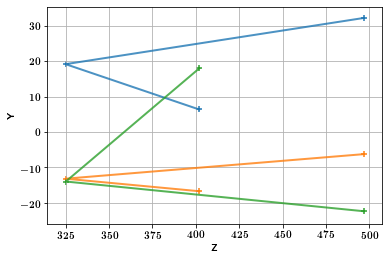

In [846]:
doing_plots()

# Something code to verify ...
## number of particles per track

for i in (reading_data(0.004,2).particle_id).values:
    #print(i)
    t = len(reading_data(0.004,2).query(f"particle_id == {i}"))
    print(t)

In [847]:
t = tracks[1]

In [848]:
for hit in t :
    df.query(f"hit_id == {hit}")

In [849]:
df['hit_id']

8074      8074
7520      7520
21995    21995
7978      7978
80413    80413
83797    83797
4136      4136
21229    21229
5125      5125
21353    21353
74651    74651
2976      2976
62051    62051
54503    54503
84738    84738
10234    10234
66846    66846
20946    20946
60748    60748
79750    79750
83011    83011
7545      7545
11128    11128
84732    84732
2222      2222
25013    25013
84819    84819
10143    10143
68794    68794
85730    85730
         ...  
13552    13552
22924    22924
84616    84616
8514      8514
80512    80512
70150    70150
24897    24897
8077      8077
54417    54417
80362    80362
61507    61507
64537    64537
58949    58949
84696    84696
18517    18517
27321    27321
75026    75026
71882    71882
729        729
9274      9274
79790    79790
71159    71159
3259      3259
72201    72201
21187    21187
20246    20246
83615    83615
11192    11192
6239      6239
83210    83210
Name: hit_id, Length: 9207, dtype: int64